## Activity
1. Use a data search tool to find an interesting, publicly available data source. Identify the format of the data from the API.
2. Read in the data into a new DataFrame object.
3. Create a visualization of at least one variable from the DataFrame using the Seaborn library.
4. Briefly interpret the visualization.

In [115]:
import sys, os
import pandas as pd
import json
from pandas.io.json import json_normalize
from datetime import datetime

### Presidential Debate Data 1960 - 2020
A quick word study of all presidential debates and candidates usage of 'America' and 'American(s).' The data comes from a Kaggle database [US Presidential Debate Transcripts 1960-2020](https://www.kaggle.com/datasets/arenagrenade/us-presidential-debate-transcripts-19602020). There were no presidential debates between 1964 – 1972.

Import all json files into dataframes and concatenate all 'dialogue' spoken by each 'actor.' Actors include candidates and moderators. The date is generated from the filename of each json file.

In [116]:
df_list = []
directory = 'data/pres_debates/'

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    with open(f) as json_data:
        data = json.load(json_data)
        df = pd.DataFrame(data['content'])
        concat_dial = df.groupby(['actor'])['dialogue'].apply(lambda x: ' '.join(x)).reset_index()
        last = len(filename)-1
        year = filename[last-8:last-4]
        month = filename[:last-12].capitalize()
        day = filename[last-11:last-9]
        s = day + " " + month + ", " + year
        d = datetime.strptime(s, '%d %B, %Y')
        concat_dial['date'] = d
        df_list.append(concat_dial)

pres_debates = pd.concat(df_list, ignore_index=True)
pres_debates.sort_values(by='date', inplace=True)
pres_debates

,actor,dialogue,date
12,Voice,This will allow three minutes and twenty secon...,1960-09-26
11,Mr. Warren,"Uh Senator Kennedy, during your brief speech ...",1960-09-26
5,Mr. Fleming,"Senator, the Vice President in his campaign ha...",1960-09-26
6,Mr. Kennedy,"Mr. Smith, Mr. Nixon. In the election of 1860,...",1960-09-26
7,Mr. Nixon,"Mr. Smith, Senator Kennedy. The things that Se...",1960-09-26
...,...,...,...
24,Participants,Former Vice President Joe Biden (D) and,2020-10-22
25,Trump,"So, as you know, 2.2 million people, modeled o...",2020-10-22
26,Welker,Good evening from Belmont University in Nashvi...,2020-10-22
22,Biden,"220,000 Americans dead. If you hear nothing el...",2020-10-22


Filter out all non-candidates based on list of last names to be kept.

In [117]:
candidates = ['Nixon', 'Kennedy', 'Ford', 'Carter', 'Reagan', 'Anderson', 'Mondale', 'Bush', 'Dukakis', 'Clinton', 'Perot', 'Dole', 'Gore', 'Kerry', 'Mccain', 'Obama', 'Romney', 'Trump', 'Biden']
cand_only = pres_debates[pres_debates['actor'].str.contains('|'.join(candidates))]
cand_only.reset_index(inplace=True, drop=True)
cand_only


,actor,dialogue,date
0,Mr. Kennedy,"Mr. Smith, Mr. Nixon. In the election of 1860,...",1960-09-26
1,Mr. Nixon,"Mr. Smith, Senator Kennedy. The things that Se...",1960-09-26
2,Mr. Kennedy,In the first place Ive never suggested that Cu...,1960-10-07
3,Mr. Nixon,"Well first of all, I dont agree with Senator K...",1960-10-07
4,Mr. Kennedy,"Good evening, Mr. Shadel. Mr. McGee, we have a...",1960-10-13
...,...,...,...
73,Clinton,"Thank you very much, Chris. And thanks to UNLV...",2016-10-19
74,Trump,"How are you doing? Thank you very much, Chris....",2020-09-29
75,Biden,"How you doing, man? Im well. Well, first of al...",2020-09-29
76,Trump,"So, as you know, 2.2 million people, modeled o...",2020-10-22


### Data Clean-up
Dataframe was exported to excel to allow for easy entry of party affiliations as well as full names of candidates. The amended data is reimported.

In [128]:
cand_clean = pd.read_excel('candidate_speech.xlsx')
cand_clean

,actor,fullname,party,dialogue,date
0,Mr. Kennedy,John F. Kennedy,D,"Mr. Smith, Mr. Nixon. In the election of 1860,...",1960-09-26
1,Mr. Nixon,Richard Nixon,R,"Mr. Smith, Senator Kennedy. The things that Se...",1960-09-26
2,Mr. Kennedy,John F. Kennedy,D,In the first place Ive never suggested that Cu...,1960-10-07
3,Mr. Nixon,Richard Nixon,R,"Well first of all, I dont agree with Senator K...",1960-10-07
4,Mr. Kennedy,John F. Kennedy,D,"Good evening, Mr. Shadel. Mr. McGee, we have a...",1960-10-13
...,...,...,...,...,...
67,Clinton,Hillary Clinton,D,"Thank you very much, Chris. And thanks to UNLV...",2016-10-19
68,Trump,Donald Trump,R,"How are you doing? Thank you very much, Chris....",2020-09-29
69,Biden,Joe Biden,D,"How you doing, man? Im well. Well, first of al...",2020-09-29
70,Trump,Donald Trump,R,"So, as you know, 2.2 million people, modeled o...",2020-10-22


In [129]:
import numpy as np
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.classify import NaiveBayesClassifier
from nltk.classify.util import accuracy
from collections import Counter
from itertools import dropwhile
from copy import deepcopy

Tokenization of each candidates dialogue into a dataframe, which is search for occurences of the string 'America.' These counts are summarized into a new column.

In [130]:
stop_words = set(stopwords.words("english"))  # load stopwords

def tokenize(data):
    # words = [w for w in data.split(" ") if w not in stop_words]
    tokens = [w for w in data.split(" ")]
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]

    new_data = Counter(words)

    for key, count in dropwhile(lambda key_count: key_count[1] >= 2, new_data.most_common()):
        del new_data[key]

    df = pd.DataFrame.from_dict(new_data.most_common())
    df.columns = ['word', 'occurrences']
    return df

word_count_dfs = []
# cand_only['America'] = cand_only.apply(lambda row : occurrences('America', tokenize(row['dialogue'])), axis = 1)
cand_clean.apply(lambda row : word_count_dfs.append(tokenize(row['dialogue'])), axis = 1)
word_count_dfs[0]

,word,occurrences
0,think,58
1,uh,38
2,states,32
3,united,30
4,years,23
...,...,...
376,kerr,2
377,ran,2
378,feel,2
379,achieving,2


### Political Keywords

A list of 50 political keywords from the University of Pittsburgh [Keywords Project](https://www.keywords.pitt.edu/williams_keywords.html). Each candidate's tokenized list of words is searched for matches and the occurrences are summed and added to the dataframe.

In [131]:
political_keywords = ['abstract', 'academic', 'brand', 'celebrity', 'civil', 'corporate', 'design', 'diversity', 'emotion', 'empathy', 'enlightenment', 'enterprise', 'environment', 'ethical', 'european', 'excellence', 'fair', 'faith', 'freedom', 'fundamentalism', 'global', 'identity', 'independent', 'information', 'legitimate', 'life', 'market', 'marriage', 'mentor', 'opinion', 'perform', 'political', 'property', 'queer', 'relativism', 'responsibility', 'rhetoric', 'rights', 'secular', 'security', 'sexuality', 'terror', 'text', 'truth', 'urban', 'value', 'victim', 'well-being', 'west', 'youth']

my_keywords = ['economy', 'job', 'healthcare', 'terror', 'education', 'tax', 'poverty', 'racism', 'crime', 'budget', 'immigration', 'climate', 'drug', 'trade', 'military', 'environment', 'energy', 'unemployment', 'abortion', 'corporation', 'globalization', 'homeless', 'inflation', 'infrastructure', 'pollution', 'conservation', 'privacy', 'family', 'war']

def occurrences(word, df):
    new_df = df.loc[df['word'].str.contains(word)]
    return new_df['occurrences'].sum()

for keyword in my_keywords:
    cand_clean[keyword] = cand_clean.apply(lambda row: occurrences(keyword, word_count_dfs[row.name]), axis = 1)

# occurrences('freedom', word_count_dfs[0])
cand_clean

,actor,fullname,party,dialogue,date,economy,job,healthcare,terror,education,...,corporation,globalization,homeless,inflation,infrastructure,pollution,conservation,privacy,family,war
0,Mr. Kennedy,John F. Kennedy,D,"Mr. Smith, Mr. Nixon. In the election of 1860,...",1960-09-26,6,3,0,0,9,...,0,0,0,0,0,0,0,0,0,0
1,Mr. Nixon,Richard Nixon,R,"Mr. Smith, Senator Kennedy. The things that Se...",1960-09-26,3,0,0,0,5,...,0,0,0,2,0,0,0,0,3,0
2,Mr. Kennedy,John F. Kennedy,D,In the first place Ive never suggested that Cu...,1960-10-07,8,3,0,0,4,...,0,0,0,0,0,0,0,0,0,8
3,Mr. Nixon,Richard Nixon,R,"Well first of all, I dont agree with Senator K...",1960-10-07,5,7,0,0,2,...,0,0,0,0,0,0,0,0,0,8
4,Mr. Kennedy,John F. Kennedy,D,"Good evening, Mr. Shadel. Mr. McGee, we have a...",1960-10-13,0,2,0,0,3,...,0,0,0,0,0,0,0,0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Clinton,Hillary Clinton,D,"Thank you very much, Chris. And thanks to UNLV...",2016-10-19,6,19,0,0,3,...,3,0,0,0,0,0,0,0,3,11
68,Trump,Donald Trump,R,"How are you doing? Thank you very much, Chris....",2020-09-29,4,14,5,0,0,...,0,0,0,0,0,0,0,0,2,2
69,Biden,Joe Biden,D,"How you doing, man? Im well. Well, first of al...",2020-09-29,9,20,7,0,0,...,0,0,0,0,0,0,0,0,4,6
70,Trump,Donald Trump,R,"So, as you know, 2.2 million people, modeled o...",2020-10-22,2,5,0,0,0,...,0,0,0,0,0,0,0,0,6,6


In [132]:
from calendar import c
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

### Political issue keywords plotted by party affiliation

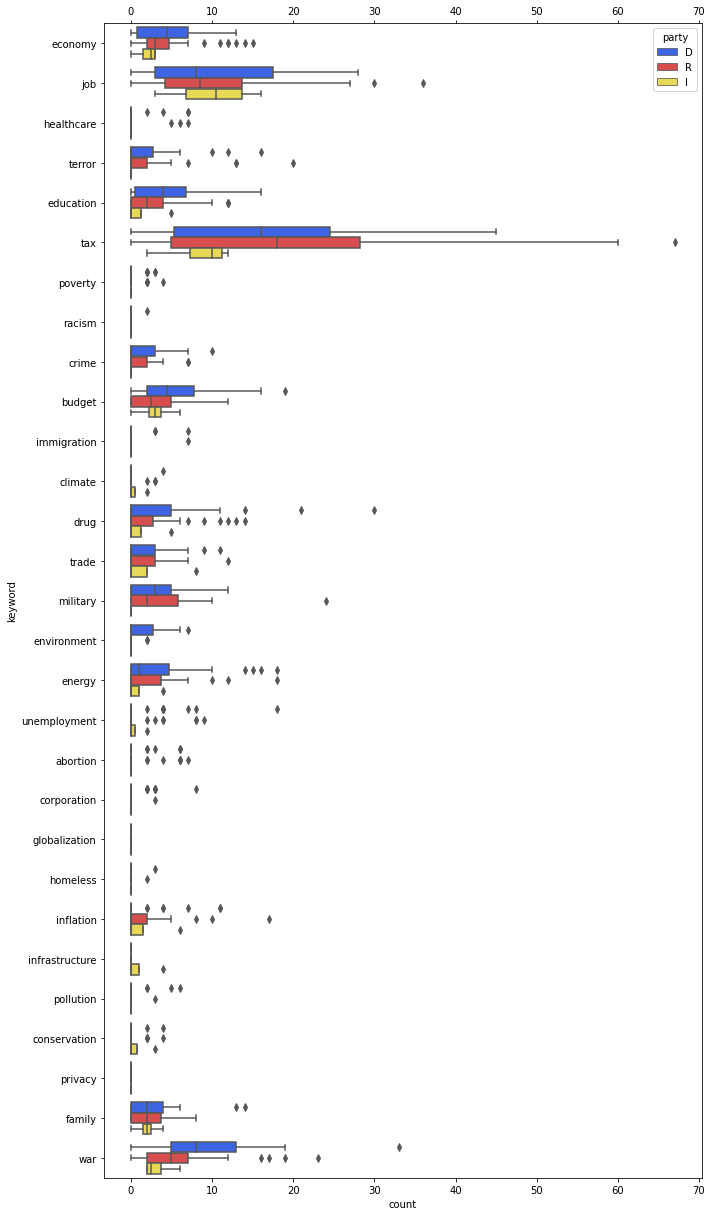

In [167]:
cand_expand = pd.melt(cand_clean, id_vars =['fullname', 'party', 'date'], value_vars =my_keywords, var_name='keyword', value_name='count')

f = plt.figure(figsize=[10,17])
ax = f.add_subplot(111)
party_pal = {"D": "#2255FF", "R": "#EC3838", "I":"#FFEB3E"}
sns.boxplot(x='count', y='keyword', data=cand_expand, hue='party', palette=party_pal, ax=ax)
plt.tick_params(axis='x',which='both',labeltop='on',labelbottom='on')
ax.xaxis.set_ticks_position('both')
f.tight_layout()
